## １．インポート＆定義

In [1]:
import pandas as pd
import numpy as np
import re
import time
import datetime
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from urllib.request import urlopen

# 前処理
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df['着順'].astype(str).str.contains('\D'))]
    df['着順'] = df['着順'].astype(int)

    # 性齢を性と年齢に分ける
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df['単勝'] = df['単勝'].astype(float)
    df['course_len'] = df['course_len'].astype(int)
    
    # 不要な列を削除
    df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手'], axis=1, inplace=True)
    
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

    return df

# 時系列に沿ってデータを分割
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list].drop(['date'], axis=1)
    test = df.loc[test_id_list].drop(['date'], axis=1)
    return train, test

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        rename_columns = average.rename(columns={'着順': f'着順_{n_samples}R', '賞金': f'賞金_{n_samples}R'})
        return rename_columns
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df
    
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho
    
class ModelEvaluator:
    def __init__(self, model, return_tables, std=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x)[:, 1], index=x.index)
        if self.std:
            # 標準化
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        
        return n_bets, int(money)
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win'] == df['馬番']]['return'].sum()
        
        return n_bets, int(money)

# 回収率を計算
def gain(return_func, x, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, money = return_func(x, threshold)
        if n_bets > lower:
            gain[n_bets] = (n_bets * 100 + money) / (n_bets * 100)
    return pd.Series(gain)

# カテゴリ変数化
def process_categorical(df, target_columns):
    copy_df = df.copy()
    for column in target_columns:
        copy_df[column] = LabelEncoder().fit_transform(copy_df[column])
    
    # target_columns以外にカテゴリ変数があれば、ダミー変数化する
    copy_df = pd.get_dummies(copy_df)   
    
    for column in target_columns:
        copy_df[column] = copy_df[column].astype('category')
    
    return copy_df

### 1.1　pickleファイル

In [2]:
results_2019 = pd.read_pickle('pickle/results3_2019.pickle')
horse_results_2019 = pd.read_pickle('pickle/horse_results_2019.pickle')
return_tables_2019 = pd.read_pickle('pickle/return_tables_2019.pickle')
peds_2019 = pd.read_pickle('pickle/peds_2019.pickle')

In [3]:
results_p = preprocessing(results_2019)
results_p.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0


In [4]:
hr = HorseResults(horse_results_2019)
results_m = hr.merge_all(results_p, n_samples=5)
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順_5R,賞金_5R
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.0
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.0
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.0
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.0
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.0


In [5]:
results_m = hr.merge_all(results_m, n_samples=9)
results_m = hr.merge_all(results_m, n_samples='all')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,性,年齢,体重,体重変化,着順_5R,賞金_5R,着順_9R,賞金_9R,着順_allR,賞金_allR
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,...,牡,2,518,-16,3.0,180.0,3.0,180.0,3.0,180.0
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,...,牡,2,496,-8,2.0,280.0,2.0,280.0,2.0,280.0
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,...,牡,2,546,6,10.0,0.0,10.0,0.0,10.0,0.0
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,...,牡,2,458,-8,4.0,110.0,4.0,110.0,4.0,110.0
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,...,牡,2,436,0,9.0,0.0,9.0,0.0,9.0,0.0


In [6]:
results_m = results_m.merge(peds_2019, left_on='horse_id', right_index=True, how='left')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania


In [7]:
categorical_columns = ['horse_id'] + [f'peds_{i}' for i in range(62)]
results_d = process_categorical(results_m, categorical_columns)

In [8]:
results_d['rank'] = results_d['着順'].map(lambda x: 1 if x < 4 else 0)
results_r = results_d.drop(['着順', '単勝', '人気'], axis=1)

In [9]:
train, test = split_data(results_r)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [10]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [11]:
me = ModelEvaluator(lgb_clf, return_tables_2019, std=False)
me.feature_importance(X_test, 10)

,features,importance
8,着順_5R,31
3,horse_id,23
9,賞金_5R,21
12,着順_allR,18
6,体重,13
228,jockey_id_05339,12
136,jockey_id_01088,10
2,斤量,9
10,着順_9R,8
232,jockey_id_05386,7


In [12]:
baseline = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


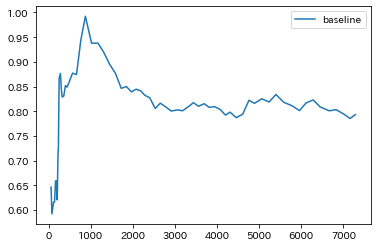

In [13]:
baseline.rename('baseline').plot(legend=True)

In [14]:
me.predict_proba(X_test)

201909040104    0.625173
201909040104    0.487987
201909040104    0.427746
201909040104    0.604138
201909040104    0.418844
                  ...   
201909050902    0.280523
201909050902    0.266709
201909050902    0.230784
201909050902    0.529579
201909050902    0.117388
Length: 13997, dtype: float64

In [15]:
proba_table = X_test[['horse_id']].copy()
proba_table['proba'] = me.predict_proba(X_test)
proba_table

,horse_id,proba
201909040104,10663,0.625173
201909040104,8494,0.487987
201909040104,8347,0.427746
201909040104,11065,0.604138
201909040104,9465,0.418844
...,...,...
201909050902,10254,0.280523
201909050902,8485,0.266709
201909050902,8919,0.230784
201909050902,10352,0.529579


In [16]:
proba_table['R'] = proba_table.index.map(lambda x: str(x)[-2:])
proba_table

,horse_id,proba,R
201909040104,10663,0.625173,04
201909040104,8494,0.487987,04
201909040104,8347,0.427746,04
201909040104,11065,0.604138,04
201909040104,9465,0.418844,04
...,...,...,...
201909050902,10254,0.280523,02
201909050902,8485,0.266709,02
201909050902,8919,0.230784,02
201909050902,10352,0.529579,02


In [17]:
proba_table.groupby('R')['proba'].mean()

R
01    0.390112
02    0.447505
03    0.468792
04    0.466651
05    0.497443
06    0.488063
07    0.508928
08    0.522037
09    0.559513
10    0.537799
11    0.544138
12    0.502007
Name: proba, dtype: float64

## 2．標準化

In [18]:
X = proba_table.loc['201906040307']['proba']

平均
$$ μ ≡ E(X) = \frac{1}{13}(X_1 + X_2 + \cdots + X_{13}) $$

In [19]:
X.mean()

0.5518352282520959

分散
$$ V(X) = \frac{1}{13}\left((X_1-E(X))^2 + (X_2-E(X))^2 + \cdots + (X_{13}-E(X))^2 \right) $$

In [20]:
X.var()

0.01719361016423315

標準偏差
$$ σ ≡ \sqrt{V(X)} $$

In [21]:
X.std()

0.13112440720259957

標準化
$$ Z_i = \frac{X_i-μ}{σ} $$

In [22]:
X_std = (X - X.mean()) / X.std()
X_std

201906040307    1.737462
201906040307    0.196809
201906040307    0.446554
201906040307   -0.075037
201906040307    0.391831
201906040307    1.309906
201906040307   -1.602881
201906040307   -0.481510
201906040307   -0.089848
201906040307   -0.089192
201906040307    0.744342
201906040307   -0.796583
201906040307   -1.691853
Name: proba, dtype: float64

In [23]:
X_std.sum()

2.220446049250313e-16

In [24]:
X_std.var()

1.0000000000000002

### 2.1　実装

In [25]:
me = ModelEvaluator(lgb_clf, return_tables_2019, std=True)

In [ ]:
gain_std = gain(me.tansho_return, X_test)

 25%|██▌       | 25/100 [00:30<01:26,  1.15s/it]

In [ ]:
baseline.rename('baseline').plot(legend=True)
gain_std.rename('std').plot(legend=True)

In [ ]:
gain_std.max()

In [ ]:
gain_std[50:]

In [ ]:
X_test.index.nunique()

In [ ]:
np.sum(me.predict(X_test, threshold=0.82))

In [ ]:
me.pred_table(X_test,  threshold=0.82)

In [ ]:
_, sample = split_data(results_m)
bets = sample[['着順', '人気', '単勝', '馬番']].merge(me.pred_table(X_test, threshold=0.82), left_index=True, right_index=True, how='right')
bets

In [ ]:
bets[bets['馬番_x'] == bets['馬番_y']]['人気'].value_counts()

In [ ]:
bets[(bets['馬番_x'] == bets['馬番_y']) & (bets['着順'] == 1)]['人気'].value_counts()

In [ ]:
len(bets[(bets['馬番_x'] == bets['馬番_y']) & (bets['着順'] == 1)]) / 71 * 100

In [ ]:
len(sample[sample['人気'] == 1])

In [ ]:
len(sample[(sample['人気'] == 1) & (sample['着順'] == 1)])

In [ ]:
rt = Return(return_tables_2019)
rt.tansho

In [ ]:
bets = rt.tansho.merge(me.pred_table(X_test, threshold=0.82), left_index=True, right_index=True, how='right')
bets

In [ ]:
wins = bets[bets['win'] == bets['馬番']]
wins

In [ ]:
wins['return'].hist()

In [ ]:
wins['return'].sum() - 71 * 100

### 2.2　2020年のデータ追加

In [ ]:
# レース結果データ
def scrape_race_results(race_id_list):
    # race_idをkeyにしてDataFrame型を格納
    race_results = {}
    for race_id in tqdm(race_id_list):
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/race/{race_id}'
            # メインとなるテーブルデータを取得
            df = pd.read_html(url)[0]
            
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')
            
            # 馬idと騎手idをスクレイピング
            horse_id_list = []
            horse_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+', a['href'])
                horse_id_list.append(horse_id[0])
                
            jockey_id_list = []
            jockey_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+', a['href'])
                jockey_id_list.append(jockey_id[0])
                
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            
            race_results[race_id] = df
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_results

# レース情報データ
def scrape_race_info(race_id_list):
    race_infos = {}
    for race_id in tqdm(race_id_list):
        try:
            url = f'https://db.netkeiba.com/race/{race_id}'
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            texts = soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[0].text + soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[1].text
            info = re.findall(r'\w+', texts)
            info_dict = {}
            for text in info:
                if text in ['芝', 'ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = int(re.findall(r'\d+', text)[0])
                if text in ['良', '稍重', '重', '不良']:
                    info_dict['ground_state'] = text
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text
            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_infos

# 馬の過去成績データ
def scrape_horse_results(horse_id_list):
    # horse_idをkeyにしてDataFrame型を格納
    horse_results = {}
    for horse_id in tqdm(horse_id_list):
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/horse/{horse_id}'
            # メインとなるテーブルデータを取得
            df = pd.read_html(url)[3]
            # 受賞歴がある馬の場合、4番目に受賞歴テーブルが来るため、5番目のデータを取得する
            if df.columns[0] == '受賞歴':
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return horse_results

# 血統データ
def scrape_peds(horse_id_list, pre_peds={}):
    # 血統データを取り出す
    peds = pre_peds
    for horse_id in tqdm(horse_id_list):
        if horse_id in peds.keys():
            continue
        try:
            url = f'https://db.netkeiba.com/horse/ped/{horse_id}'
            df = pd.read_html(url)[0]
            
            # 重複を削除して1列のSeries型データに治す
            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i]
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
            
            ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return peds

# 払い戻しデータ
def scrape_return_tables(race_id_list, pre_return_tables={}):
    return_tables = pre_return_tables
    for race_id in tqdm(race_id_list):
        if race_id in return_tables.keys():
            continue
        try:
            time.sleep(1)
            url = f'https://db.netkeiba.com/race/{race_id}'
            
            # 複勝やワイドなどが区切られてしまうため、改行コードを文字列に変換して後でsplitする
            f = urlopen(url)
            html = f.read()
            html = html.replace(b'<br />', b'br')            
            dfs = pd.read_html(html)
            
            # dfsの2番目に単勝～馬連、3番目にワイド～3連単がある
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
            
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return return_tables

In [ ]:
# レースIDのリストを作る
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = f'2020{str(place).zfill(2)}{str(kai).zfill(2)}{str(day).zfill(2)}{str(r).zfill(2)}'
                race_id_list.append(race_id)

In [ ]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# race_results = scrape_race_results(race_id_list)

# indexをrace_idにする
# for key in race_results:
#     race_results[key].index = [key] * len(race_results[key])

# 一つのDataFrame型のデータにまとめる
# race_results_df = pd.concat([race_results[key] for key in race_results], sort=False)

# pickleファイルに保存
# race_results_df.to_pickle('pickle/results_2020.pickle')

In [ ]:
results_2020 = pd.read_pickle('pickle/results_2020.pickle')

In [ ]:
#レースID一覧を取得してスクレイピング(再実行すると時間かかるのでコメント)
# race_id_list = results_2020.index.unique()
# race_infos = scrape_race_info(race_id_list)

#DataFrame型にする
# race_infos = pd.DataFrame(race_infos).T

# resultsに結合
# results_addinfo = results_2020.merge(race_infos, left_index=True, right_index=True, how='inner')

# pickleファイルに保存
# results_addinfo.to_pickle('pickle/results2_2020.pickle')
# race_infos.to_pickle('pickle/race_infos_2020.pickle')

In [ ]:
results_2020 = pd.read_pickle('pickle/results2_2020.pickle')

In [ ]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# horse_id_list = results_2020['horse_id'].unique()
# horse_results = scrape_horse_results(horse_id_list)

# インデックスをhorse_idにする
# for key in horse_results:
#     horse_results[key].index = [key] * len(horse_results[key])
    
# 一つのDataFrame型のデータにまとめる
# horse_results = pd.concat([horse_results[key] for key in horse_results])

# pickleファイルに保存
# horse_results.to_pickle('pickle/horse_results_2020.pickle')

In [ ]:
horse_results_2020 = pd.read_pickle('pickle/horse_results_2020.pickle')

In [ ]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# horse_id_list = results_2020['horse_id'].unique()
# peds = scrape_peds(horse_id_list)

# 一つのDataFrame型のデータにまとめる
# peds = pd.concat([peds[key] for key in peds], axis=1).T

# 列名を変更
# peds = peds.add_prefix('peds_')

# pickleファイルに保存
# peds.to_pickle('pickle/peds_2020.pickle')

In [ ]:
peds_2020 = pd.read_pickle('pickle/peds_2020.pickle')

In [ ]:
results_p = preprocessing(results_2020)

In [ ]:
# スクレイピングしてデータを保存(再実行すると時間かかるのでコメント)
# race_id_list = results_p.index.unique()
# return_tables = scrape_return_tables(race_id_list)

# インデックスをrace_idにする
# for key in return_tables.keys():
#     return_tables[key].index = [key]*len(return_tables[key])

# 一つのDataFrame型のデータにまとめる
# return_tables = pd.concat([return_tables[key] for key in return_tables.keys()])

# pickleファイルに保存
# return_tables.to_pickle('pickle/return_tables_2020.pickle')

In [ ]:
return_tables_2020 = pd.read_pickle('pickle/return_tables_2020.pickle')

In [ ]:
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

In [ ]:
results = pd.concat([results_2019, results_2020])
results.to_pickle('pickle/results.pickle')

In [ ]:
horse_results = update_data(horse_results_2019, horse_results_2020)
horse_results.to_pickle('pickle/horse_results.pickle')

In [ ]:
peds = update_data(peds_2019, peds_2020)
peds.to_pickle('pickle/peds.pickle')

In [ ]:
return_tables = pd.concat([return_tables_2019, return_tables_2020])
return_tables.to_pickle('pickle/return_tables.pickle')

## 3．出馬表データを作る

In [ ]:
class ShutubaTable:
    def __init__(self):
        self.shutuba_tables = pd.DataFrame()
        # preprocessing後の変数
        self.shutuba_tables_p = pd.DataFrame()
        # horse_resultsをmergeした後の変数
        self.shutuba_tables_h = pd.DataFrame()
        # pedsをmergeした後の変数
        self.shutuba_tables_pe = pd.DataFrame()
        
    def scrape(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = f'https://race.netkeiba.com/race/shutuba.html?race_id={race_id}'
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            # race_data
            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    df['weather'] = [text] * len(df)
                if text in ["良", "稍重", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            df['horse_id'] = horse_id_list

            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            self.shutuba_tables = self.shutuba_tables.append(df)
            time.sleep(1)
    
    def preprocessing(self):
        df = self.shutuba_tables.copy()
        
        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df['馬体重(増減)'] != '--']
        df['体重'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].astype(int)
        
        # 日付をdatetime型に変更
        df['date'] = pd.to_datetime(df['date'])

        # データをint, floatに変換
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

    
        # 必要な列だけにする
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather', 'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢', '体重', '体重変化']]

        self.shutuba_tables_p = df.rename(columns={'枠': '枠番'})

    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.shutuba_tables_h = self.shutuba_tables_p.copy()
        for n_samples in n_samples_list:
            self.shutuba_tables_h = hr.merge_all(self.shutuba_tables_h, n_samples=n_samples)
    
    def merge_peds(self, peds):
        self.shutuba_tables_pe = self.shutuba_tables_h.merge(peds, left_on='horse_id', right_index=True, how='left')
        self.no_peds = self.shutuba_tables_pe[self.shutuba_tables_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds):
            print('scrape peds at horse_id_list "no_peds"')

In [ ]:
st = ShutubaTable()
st.scrape(['202004020605'], '2020/08/09')
st.preprocessing()
st.merge_horse_results(hr)
st.merge_peds(peds)

In [ ]:
st.shutuba_tables_pe